<a href="https://colab.research.google.com/github/j-ranasinghe/nlp_cw/blob/main/Solution_GroupH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CM4603 – Coursework 1 (Group)
#### November 2023

### Group: H

Name 1: Anuttara Rajasinghe |
IIT ID: 20210216 |
RGU ID: 2117946

Name 2: Janani  Ranasinghe |
IIT ID: 20210926 |
RGU ID: 2122095

Name 3: Vishmi Herath |
IIT ID: 20210503 |
RGU ID: 2117528

### Answer to Task 1

    Describe the dataset, any insights you gained about the data and the effectiveness of the different (subword) tokenization schemes tried out.

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [148]:
import json

# Replace 'path_to_your_file' with the actual path in your Google Drive
file_path = '/content/drive/MyDrive/NLP CW/full-combined-dataset.json'

# Load the JSON data
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)


In [149]:
# Extract only the specified columns
filtered_data = []
for entry in data:
    filtered_entry = {
        "title": entry.get("title"),
        "lang": entry.get("lang"),
        "rating": entry.get("rating"),
        "helpfulVotes": entry.get("helpfulVotes"),
        "text": entry.get("text"),
        "PlaceName": entry.get("placeInfo", {}).get("name"),
        "PlaceRating": entry.get("placeInfo", {}).get("rating")
    }
    filtered_data.append(filtered_entry)


In [150]:
filtered_data[:2]

[{'title': 'Terrible experience. Waste of time, money and nerves. Stay away.',
  'lang': 'en',
  'rating': 1,
  'helpfulVotes': 1,
  'text': 'Well, no.   Big no. \nFirst of all, before booking, please go through all these comments. Look at the pictures. Not posted by the property but from guest. The place have a great potential but as of today it is just a scam. Place is undeveloped, rooms are nasty. Food terrible. All three above aspects can be fixed easily and reading that this "in a jungle" makes no sense. We travel to Sri Lanka often, staying in boutique hotels but also in a real jungle. All places can be clean and nice disputing the fact of not easy environment around. Same w/ food. Staying "in a jungle" explain nasty food served? Having so many option for low-key or upscale Sri Lanka\' culinary possibilities? \n\nSo we did claim many times issues on site. Zero interest. Management\'s reaction: it is what it is, deal with it. \nImmediate decision to leave. After one night in dirty

In [151]:
print(len(filtered_data))

10127


In [152]:
#This is done to identify the non english characters in the dataset
def clean_non_english_entries(data):
    en_entries = [entry for entry in data if entry.get("lang") == "en"]
    non_en_entries = [entry for entry in data if entry.get("lang") != "en"]

    return en_entries, non_en_entries

cleaned_data, deleted_data = clean_non_english_entries(filtered_data)

print(f"Number of English entries: {len(cleaned_data)}")
print(f"Number of non-English entries removed from the dataset: {len(deleted_data)}")

Number of English entries: 8966
Number of non-English entries removed from the dataset: 1161


In [153]:
#We can see that the removed data is not english
deleted_data[:2]

[{'title': 'horrible',
  'lang': 'fr',
  'rating': 1,
  'helpfulVotes': 0,
  'text': "Établissement non entretenu et géré par des voleurs. escroquerie sur la facture qui après vérification a été modifiée car le personnel a tenté de nous faire payer les entrées et sorties de l'hôtel ainsi que des plats non commandés. Mais la note a été subtilisée au moment du paiement et comme la monnaie de paiement utilisée était les roupies je n'ai pas vu et ne me doutais pas qu'ils oseraient mettre un montant supérieur. L'hôtel ne veut rien entendre. Plusieurs démarches ont été entreprises depuis. Attention soyez très vigilants.",
  'PlaceName': 'Ella Jungle Resort',
  'PlaceRating': 4},
 {'title': 'Arnaques sur la facture et les services facturés.',
  'lang': 'fr',
  'rating': 1,
  'helpfulVotes': 1,
  'text': 'Attention personnel malhonnête. séjour hallucinant. Le «\xa0manager\xa0» veut faire payer les entrées et sorties de l’hôtel (accès par 4x4 et télésiège) et fait gonfler les factures au moment

In [154]:
# Function to find duplicates based on specific fields
def find_duplicates(data, keys=["title", "rating", "helpfulVotes", "text", "PlaceName", "PlaceRating"]):
    seen = set()
    duplicates = []

    for entry in data:
        # Create a tuple of values from specified keys to uniquely identify each entry
        identifier = tuple(entry.get(key) for key in keys)

        if identifier in seen:
            duplicates.append(entry)
        else:
            seen.add(identifier)

    print(f"Total number of entries: {len(data)}")
    print(f"Number of duplicate entries: {len(duplicates)}")

    return duplicates

duplicates = find_duplicates(cleaned_data)

Total number of entries: 8966
Number of duplicate entries: 0


In [155]:
import pandas as pd

# Load the data into a DataFrame
df = pd.DataFrame(cleaned_data)

# Summary statistics for numerical columns
print("Summary Statistics:")
print(df[['rating', 'helpfulVotes', 'PlaceRating']].describe())

Summary Statistics:
            rating  helpfulVotes  PlaceRating
count  8966.000000   8966.000000  8966.000000
mean      4.663618      0.214588     4.545394
std       0.825518      1.060108     0.311255
min       1.000000     -1.000000     4.000000
25%       5.000000      0.000000     4.500000
50%       5.000000      0.000000     4.500000
75%       5.000000      0.000000     4.500000
max       5.000000     60.000000     5.000000


In [157]:
print(f'Shape of dataset : {df.shape}')

Shape of dataset : (8966, 7)


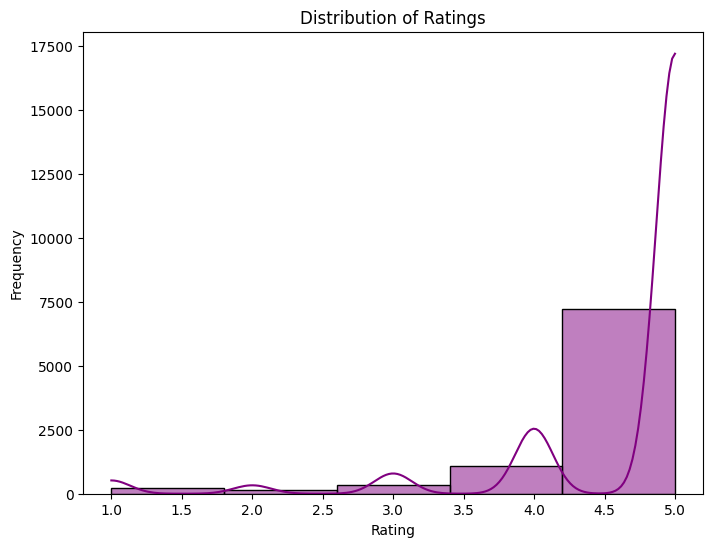

In [160]:
import matplotlib.pyplot as plt
import seaborn as sns

# Rating Distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['rating'], bins=5, kde=True, color='purple')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [161]:
# Calculate review length in words
df['review_length'] = df['text'].apply(lambda x: len(x.split()))

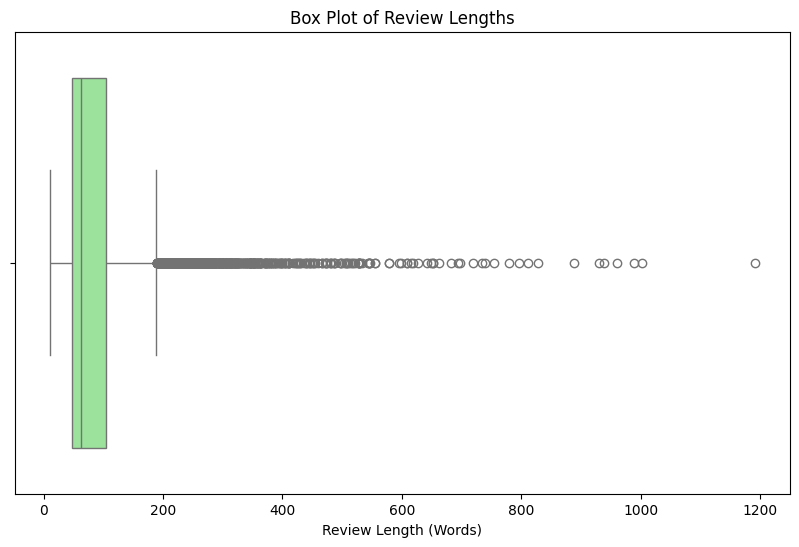

In [162]:
# Box Plot of Review Lengths
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['review_length'], color='lightgreen')
plt.title('Box Plot of Review Lengths')
plt.xlabel('Review Length (Words)')

plt.show()

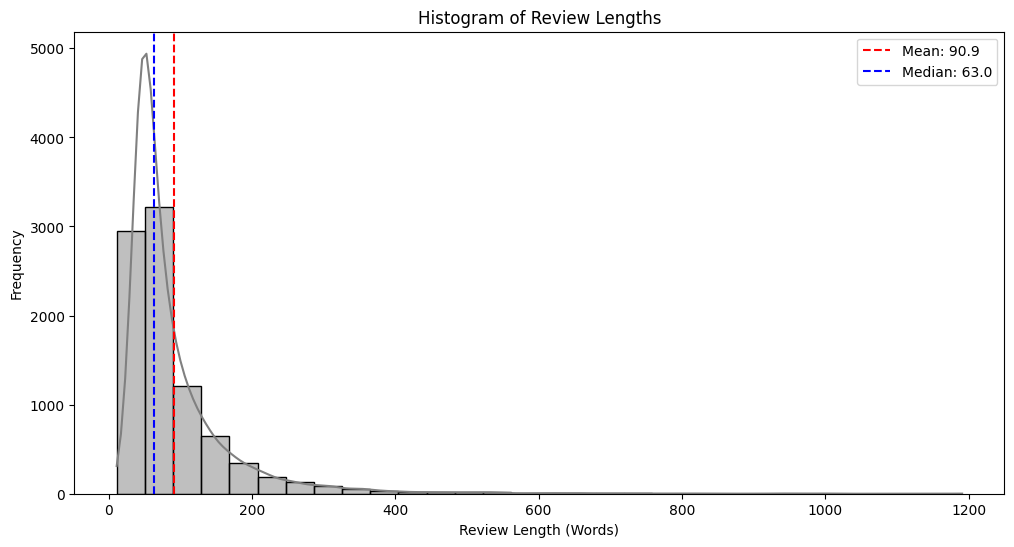

In [163]:
# calculate the mean and median for the review length
mean_length = df['review_length'].mean()
median_length = df['review_length'].median()

# Plot the histogram for review length
plt.figure(figsize=(12, 6))
sns.histplot(df['review_length'], bins= 30, kde=True, color="grey")
plt.axvline(mean_length, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_length:.1f}')
plt.axvline(median_length, color='blue', linestyle='--', linewidth=1.5, label=f'Median: {median_length:.1f}')

plt.title("Histogram of Review Lengths")
plt.xlabel("Review Length (Words)")
plt.ylabel("Frequency")
plt.legend()

plt.show()

In [164]:
# Calculate the 5th and 95th percentiles of review lengths
lower_threshold = df['review_length'].quantile(0.02)
upper_threshold = df['review_length'].quantile(0.98)

# Print the threshold values
print(f"5th Percentile Threshold (Minimum Length): {lower_threshold}")
print(f"95th Percentile Threshold (Maximum Length): {upper_threshold}\n")

# Filter out the reviews below the 5th percentile and above the 95th percentile
lower_bound = df[df['review_length'] < lower_threshold]
upper_bound = df[df['review_length'] > upper_threshold]

# Print the number of reviews below the 5th and above the 95th percentiles
print(f"Number of reviews below the 2nd percentile: {len(lower_bound)}")
print(f"Number of reviews above the 98th percentile: {len(upper_bound)}")



5th Percentile Threshold (Minimum Length): 32.0
95th Percentile Threshold (Maximum Length): 328.0

Number of reviews below the 2nd percentile: 162
Number of reviews above the 98th percentile: 179


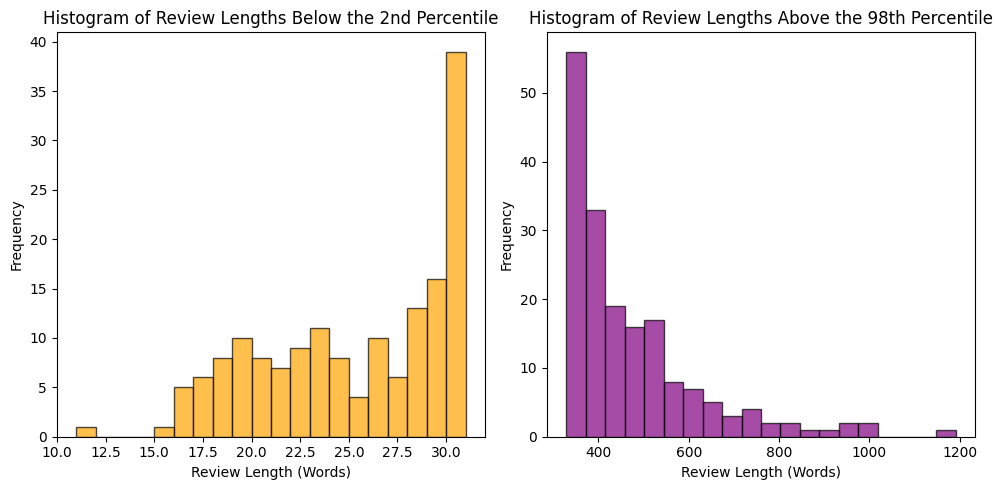

In [165]:
plt.figure(figsize=(10, 5))

# Plot histogram for reviews below the 5th percentile
plt.subplot(1, 2, 1)
plt.hist(lower_bound['review_length'], bins=20, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel('Review Length (Words)')
plt.ylabel('Frequency')
plt.title('Histogram of Review Lengths Below the 2nd Percentile')

# Plot histogram for reviews above the 95th percentile
plt.subplot(1, 2, 2)
plt.hist(upper_bound['review_length'], bins=20, color='purple', edgecolor='black', alpha=0.7)
plt.xlabel('Review Length (Words)')
plt.ylabel('Frequency')
plt.title('Histogram of Review Lengths Above the 98th Percentile')

plt.tight_layout()
plt.show()

In [166]:
# drop the reviews less than teh 2nd percentile and higher than the 98th percentile
df_cleaned = df[(df['review_length'] >= lower_threshold) & (df['review_length'] <= upper_threshold)].copy()

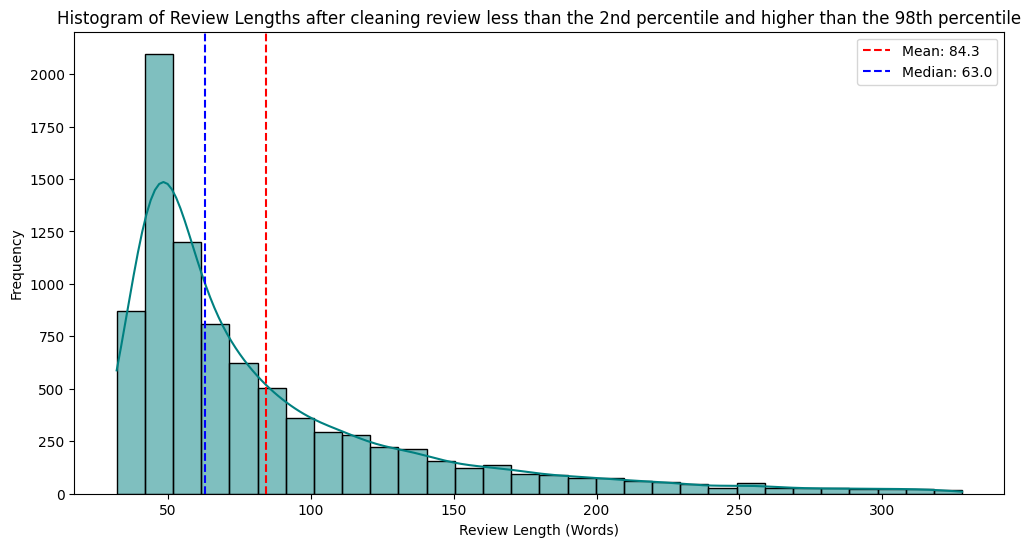

In [174]:
# calculate the mean and median for the review length after cleaning review less than teh 2nd percentile and higher than the 98th percentile
mean_length = df_cleaned['review_length'].mean()
median_length = df_cleaned['review_length'].median()

# Plot the histogram for review length
plt.figure(figsize=(12, 6))
sns.histplot(df_cleaned['review_length'], bins= 30, kde=True, color="teal")
plt.axvline(mean_length, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_length:.1f}')
plt.axvline(median_length, color='blue', linestyle='--', linewidth=1.5, label=f'Median: {median_length:.1f}')

plt.title("Histogram of Review Lengths after cleaning review less than the 2nd percentile and higher than the 98th percentile")
plt.xlabel("Review Length (Words)")
plt.ylabel("Frequency")
plt.legend()

plt.show()

In [168]:
print(f'Shape of dataset after cleaning: {df_cleaned.shape}')

Shape of dataset after cleaning: (8625, 8)


In [169]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Assuming cleaned_data is already defined
data = df_cleaned

# Selecting only numeric columns for SMOTE
X = data[['helpfulVotes', 'PlaceRating']]
y = data['rating']

# Apply SMOTE for oversampling the minority classes
smote = SMOTE(sampling_strategy='auto', random_state=42)  # Balances all classes
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert resampled data back to DataFrame
resampled_data = pd.DataFrame(X_resampled, columns=X.columns)

# Add 'rating' column to the resampled DataFrame
resampled_data['rating'] = y_resampled

# Add the 'text' column (or other non-numeric columns) back to the resampled DataFrame
# We will use the index of the original data to retrieve the corresponding 'text' values

# Create a DataFrame with the original data to map 'text' correctly
original_data = data[['text']]

# For each resampled row, append the corresponding 'text' values from the original dataset
# We use SMOTE to generate the resampled data and collect the original 'text' values
resampled_text = []
for i in range(len(X_resampled)):
    # If the resampled row corresponds to an original sample, retrieve its 'text'
    original_index = X.index[i % len(X)]  # Wrap around if resampling duplicates the same index
    resampled_text.append(original_data.loc[original_index, 'text'])

# Add the 'text' values to the resampled DataFrame
resampled_data['text'] = resampled_text

# Show the distribution of the 'rating' column after resampling
print("Distribution of ratings after resampling:")
print(resampled_data['rating'].value_counts())


Distribution of ratings after resampling:
rating
1    6994
5    6994
2    6994
4    6994
3    6994
Name: count, dtype: int64


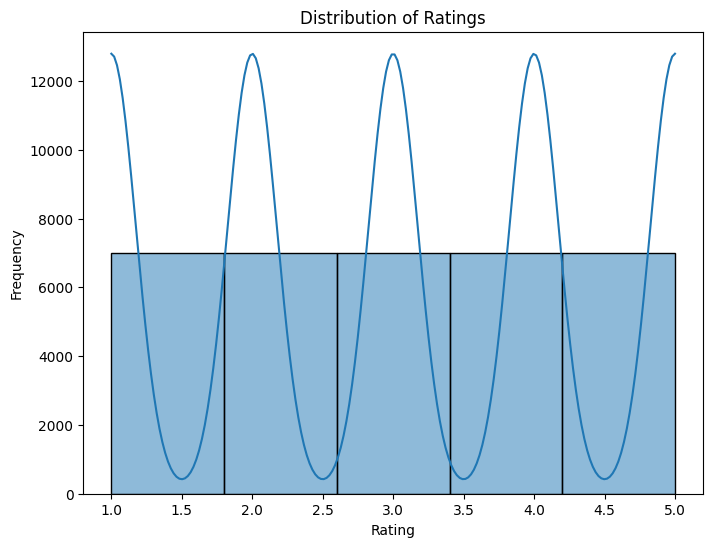

In [172]:
# Rating Distribution
plt.figure(figsize=(8, 6))
sns.histplot(resampled_data['rating'], bins=5, kde=True)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

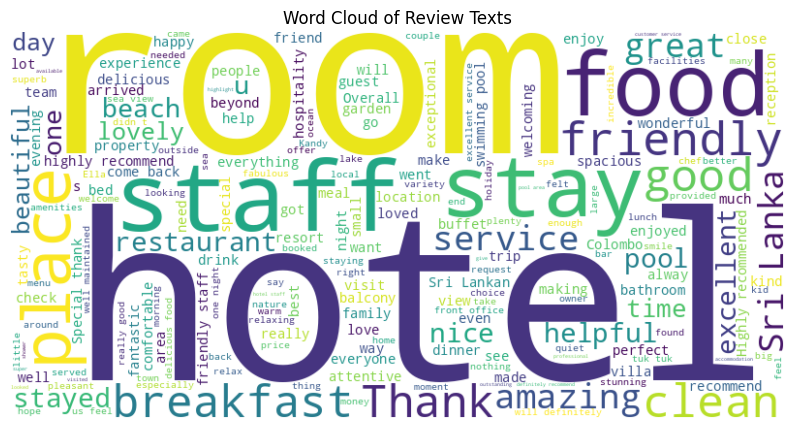

In [173]:

from wordcloud import WordCloud

# Join all review texts
all_text = " ".join(resampled_data['text'].dropna())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Review Texts")
plt.show()

Explain the challenges encountered and the observations based on the output above

### Answer to Task 2

Describe the classification dataset, its dimensions, preprocessing steps, numbers of classes taken for classification, the which feature extraction techniques were performed.

In [ ]:
# Insert code for Task 2

Describe the final dataset shapes of the featuresets extracted.

### Answer to Task 3

Justify the 3 non-deep learning algorithms you are using for classification.

In [ ]:
# Insert code for Task 3

Compare and interpret the results of the different algorithms and feature extraction methods on the text classification task.

### Answer to Task 4

Describe the contextual embedding used and it's effect on the performance of the algorithms selected in Task 3.

In [ ]:
# Insert code for Task 4

Compare the deep learning algorithm results with that of the 3 non-deep learning algorithms and interpret the overal results